In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import pickle
from collections import defaultdict
import sys, re
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

home_dir = '/content/drive/My Drive/11747/'

# dataset path
train_path = home_dir + 'topicclass/topicclass_train.txt'
valid_path = home_dir + 'topicclass/topicclass_valid.txt'
test_path = home_dir + 'topicclass/topicclass_test.txt'

# Data Preprocessing

In [0]:
def load_data(filename):
  text = []
  labels = []
  length_vec = []
  word_dict = defaultdict(int)
  with open(filename, "r") as f:
      for line in f:
          tag, words = line.strip().split(" ||| ")
          # remove weird words such as @
          s = re.sub(r"[^A-Za-z0-9()!#$%&*+,./:;<=>?\[\\\]{|~}–\"\-\'\`]", " ", words)
          text.append(s)
          labels.append(tag)
          s_split = s.split()
          for w in s_split:
              word_dict[w] += 1
          length_vec.append(len(s_split))
      return text, labels, word_dict, length_vec

In [0]:
x_train, y_train, word_dict_train, length_vec_train = load_data(train_path)
print("total train set: ", len(x_train))
print('number of all vocab', len(word_dict_train))

total train set:  253909
number of all vocab 131801


(array([1.7629e+04, 5.6596e+04, 6.9755e+04, 5.3531e+04, 3.1038e+04,
        1.5374e+04, 7.0710e+03, 2.8770e+03, 3.4000e+01, 4.0000e+00]),
 array([ 5. , 12.1, 19.2, 26.3, 33.4, 40.5, 47.6, 54.7, 61.8, 68.9, 76. ]),
 <a list of 10 Patch objects>)

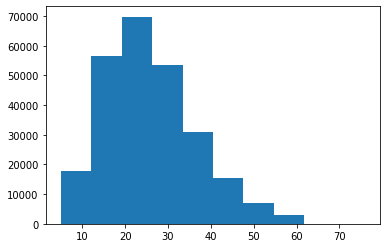

In [0]:
plt.hist(length_vec_train)

In [0]:
max(length_vec_train)

76

In [0]:
num_classes = len(set(y_train))
label2idx_dict = {}
i = 0
for label in set(y_train):
  label2idx_dict[label] = i
  i += 1

label2idx_dict

{'Agriculture, food and drink': 5,
 'Art and architecture': 1,
 'Engineering and technology': 3,
 'Geography and places': 0,
 'History': 6,
 'Language and literature': 15,
 'Mathematics': 10,
 'Media and drama': 11,
 'Miscellaneous': 7,
 'Music': 13,
 'Natural sciences': 2,
 'Philosophy and religion': 9,
 'Social sciences and society': 12,
 'Sports and recreation': 14,
 'Video games': 4,
 'Warfare': 8}

In [0]:
def get_word2idx(dic, min_freq=3):
  index_dic = {}
  i = 0
  index_dic['<pad>'] = i # 0 for pad
  i += 1
  index_dic['<unk>'] = i # 1 for unk
  i += 1
  for k,v in dic.items():
    if v >= min_freq:
      index_dic[k] = i
      i += 1
  return index_dic

word2idx_train = get_word2idx(word_dict_train)
print("length of indexed vocab", len(word2idx_train))

length of indexed vocab 61867


In [0]:
text_size = 76
n_features = 300


def text_to_vector(text):
  # remove weird characters
  s = re.sub(r"[^A-Za-z0-9()!#$%&*+,./:;<=>?\[\\\]{|~}\"\-\'\`]", " ", text)

  sent = s.split()[:text_size]
  ret = [0]*text_size
  for i in range(len(sent)):
    wd = sent[i]
    offset = text_size - len(sent)
    if wd in word2idx_train:
      ret[i+offset] = word2idx_train[wd]
    else:
      ret[i+offset] = word2idx_train['<unk>']
  return ret
    

def get_feature(data):
  feat = []
  for sent in data:
    v = text_to_vector(sent)
    feat.append(v)
  return np.array(feat)

feature_train = get_feature(x_train)
feature_train

array([[   0,    0,    0, ...,   36,   37,   38],
       [   0,    0,    0, ...,   35,   55,   38],
       [   0,    0,    0, ...,   77,    1,   38],
       ...,
       [   0,    0,    0, ...,   19,  933,   38],
       [   0,    0,    0, ...,  199, 1635,   38],
       [   0,    0,    0, ..., 2240, 1339,   38]])

In [0]:
def encode_label(label):
  encode = []
  for l in label:
    if l == 'Media and darama': l = 'Media and drama'
    encode.append(label2idx_dict[l])
  return np.array(encode)

y_train_encode = encode_label(y_train)
y_train_encode

array([12, 14, 12, ...,  2,  1,  8])

In [0]:
valid_path = home_dir + 'topicclass/topicclass_valid.txt'
x_valid, y_valid, _, length_vec_valid = load_data(valid_path)
print("total valid set shape: ", len(x_valid))

feature_valid = get_feature(x_valid)
y_valid_encode = encode_label(y_valid)

total valid set shape:  643


In [0]:
test_path = home_dir + 'topicclass/topicclass_test.txt'
x_test, _, _, _ = load_data(test_path)
print("test set shape: ", len(x_test))

feature_test = get_feature(x_test)

test set shape:  697


In [0]:
# save and load embedding matrix
def save(data, title):
  pickle.dump(data, open( home_dir + title + ".pkl", "wb" ))

def load(title):
  data = pickle.load(open( home_dir + title + ".pkl", "rb" )) 
  return data

In [0]:
def get_word_embedding_matrix(word2idx_dict):
    # randomize embedding
    M = (np.random.rand(len(word2idx_dict), 300)-0.5)/2
    pretrain_used = 0
    with open(home_dir + 'cc.en.300.vec', 'r') as f:
      total_pretrained_vec, dim = f.readline().split()
      print("total pretrained vec:", total_pretrained_vec, "dim:", dim)
      for line in f:
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx_dict:
          M[word2idx_dict[word]] = np.array(tokens[1:])
          pretrain_used += 1

      print("%s out of %s (%f%%) words has pretrained embedding" % (pretrain_used, len(word2idx_dict), pretrain_used/len(word2idx_dict)) )
      return M

In [0]:
embedding = get_word_embedding_matrix(word2idx_train)
save(embedding, "embedding_lower")

total pretrained vec: 2000000 dim: 300
45098 out of 54083 (0.833866%) words has pretrained embedding


In [0]:
embedding = load("embedding")
embedding.shape

(61867, 300)

# Model Train

### Cite: https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# dataloaders
train_data = TensorDataset(torch.from_numpy(feature_train), torch.from_numpy(y_train_encode))
valid_data = TensorDataset(torch.from_numpy(feature_valid), torch.from_numpy(y_valid_encode))

batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [0]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, bidirectional=True, drop_prob=0.2):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=True, 
                            dropout=drop_prob, 
                            batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.2)
        
        # fc layer
        self.fc = nn.Linear(hidden_dim * 2, output_size)

        # sigmoid layer
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings: [batch size, sentence length, embedding dim]
        embeds = self.embedding(x)
        
        # lstm
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        # pick the last word of each seq
        lstm_out = lstm_out[:, -1, :]
        
        # dropout layer
        out = self.dropout(lstm_out)

        #  FC layer: [1, num_classes]
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)
        
        # return sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
          # multipy by 2 since bidirectional
            hidden = (weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
            
        else:
            hidden = (weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(2*self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

# Instantiate the model w/ hyperparams
vocab_size = len(word2idx_train)
output_size = num_classes
embedding_dim = n_features
hidden_dim = 300
n_layers = 2

model = LSTMClassifier(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, bidirectional=True)

embedding = load("embedding")
embedding = torch.from_numpy(embedding)
model.embedding.weight.data.copy_(embedding)

print(model)

LSTMClassifier(
  (embedding): Embedding(61867, 300)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=600, out_features=16, bias=True)
  (sig): Sigmoid()
)


In [0]:
def save(model, ep):
  torch.save(model.state_dict(), home_dir+"ass1_epoch"+str(ep)+".pt")
  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [0]:
train_on_gpu = True

# loss and optimization functions
lr = 0.0005

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model = model.to(device)
criterion = criterion.to(device)

epochs = 10
counter = 0
print_every = 500
clip = 5 # gradient clipping

# # move model to GPU, if available
if(train_on_gpu):
    model.cuda()


In [0]:
model.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = model.init_hidden(batch_size)

    # batch loop
    acc_train = []
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history           
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        model.zero_grad()

        inputs = inputs.type(torch.LongTensor)
        if (train_on_gpu):
          inputs = inputs.cuda()
        
        # get the output from the model
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()

        # train acc
        predict_train = torch.argmax(output, dim=-1)
        acc_train.append(torch.sum(predict_train == labels).item()/batch_size)

        # `clip_grad_norm` helps prevent the exploding gradient problem in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = model.init_hidden(batch_size)
            val_losses = []
            acc = []
            model.eval()
            for inputs, labels in valid_loader:
             
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if (train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                if (train_on_gpu):
                  inputs = inputs.cuda()
                
                output, val_h = model(inputs, val_h)
                val_loss = criterion(output, labels)
                
                predict = torch.argmax(output, dim=-1)
                acc.append(torch.sum(predict == labels).item()/batch_size)

                val_losses.append(val_loss.item())

            model.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Train acc: {:.6f}".format(np.mean(acc_train)),
                  "Val acc: {:.6f}".format(np.mean(acc)))
            
    save(model, e)
    print("saving epoch", e)

Epoch: 1/10... Step: 500... Loss: 2.613619... Val Loss: 2.567981 Train acc: 0.130875 Val acc: 0.104688
Epoch: 1/10... Step: 1000... Loss: 2.484241... Val Loss: 2.551818 Train acc: 0.131719 Val acc: 0.104688
Epoch: 1/10... Step: 1500... Loss: 2.671811... Val Loss: 2.557756 Train acc: 0.131667 Val acc: 0.104688
Epoch: 1/10... Step: 2000... Loss: 2.598871... Val Loss: 2.556906 Train acc: 0.131703 Val acc: 0.104688
Epoch: 1/10... Step: 2500... Loss: 2.551941... Val Loss: 2.533640 Train acc: 0.131637 Val acc: 0.104688
Epoch: 1/10... Step: 3000... Loss: 2.718120... Val Loss: 2.549231 Train acc: 0.131656 Val acc: 0.104688
Epoch: 1/10... Step: 3500... Loss: 2.446483... Val Loss: 2.555588 Train acc: 0.131321 Val acc: 0.104688
Epoch: 1/10... Step: 4000... Loss: 2.671870... Val Loss: 2.553661 Train acc: 0.130953 Val acc: 0.104688
Epoch: 1/10... Step: 4500... Loss: 2.489996... Val Loss: 2.536942 Train acc: 0.130868 Val acc: 0.104688
Epoch: 1/10... Step: 5000... Loss: 2.570037... Val Loss: 2.564008

In [0]:
def model_load(name):
  model =  model = LSTMClassifier(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, bidirectional=True)
  model.load_state_dict(torch.load(home_dir+name))
  model.eval()
  model.to(device)
  return model


In [0]:
train_on_gpu = True
model = model_load("ass1_epoch9.pt")

test_losses = [] # track loss
num_correct = 0.0
# acc = []
# init hidden state
h = model.init_hidden(batch_size)
model.eval()
# iterate over test data
for inputs, labels in valid_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    
    inputs = inputs.type(torch.LongTensor)
    if (train_on_gpu):
       inputs = inputs.cuda()
    
    # get predicted outputs
    output, h = model(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    predict = torch.argmax(output, dim=-1)
    
    num_correct += torch.sum(predict == labels)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(valid_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 2.037
Test accuracy: 0.806
